# The House Price Prediction
## Team 4: Vicky Van Der Wagt, Halee Staggs, Bethany Wang

Changes 11/19/22
    
*  Inserted data cleaning setps
* Although earlier we talked about replacing missing values with item that correlates to it the most, after looking at graphs, they do not have clear linear relationships. Therefore, I used the averages for now. Will read more projects to see what else they did. 
* Also added discretization (5 categories for longitude, 3 categories for latitude). Then added a loc_cat column (location category) which has the concatenated values. Clear relationship between loc_cat and price
* For duplicate ids, removed the oldest entry and only kept the most recent one. 
* Removed outliers using quartiles in iqr for sqft_living and sqft_lot since those had the most extreme values. Also concluded the 33 bedroom entry was a mistake, as the square footage was less than 2000(definitely could not fit 33 bedrooms). Therefore, replaced it same method as other bedrooms (with average bedrooms). 
* Holding off on deleting most columns until we decide what is relevant to our models

Vicky to do (feel free to add if you find more that needs cleaning)
* Write introduction
* Investigate what other people did to fill in missing bedrooms, bathrooms, sqft living

Changes 11/24/22
1. Remove outliers from price. 

2. Updated "yr_renovated" to Yes/No. Only ~900 with yes. 

3. Converted year built to age. Added column.

4. Normalized outcome variable with square root transformation instead of log. Original data was positively skewed, and then log transformed was negatively skewed so log was not the right method.  

5. Reduced dimensions for lat/long location groups. Added a 3X3 grid to compare. There were 3 long/lat groups that only ontained 1 house. By reducing dimensions, it grouped everything so each area is better represented. When looking at the bar chart, there are 4 distinct price levels. I think we can reduce the location dimensions even further into 3 groups (North, Central, South). The prices differences go North-South more so than East-West. This will help with final model to reduce number of dummy variables.

6. Updated numerical/categorical/ordinal lists of variables. 

7. **Most of our variables are discrete. We cannot compute mean and standard deviation for them. Udated missing values to fill with median. Use PMF for distributions. Median house prices for Washington state listed here: https://ofm.wa.gov/washington-data-research/statewide-data/washington-trends/economic-trends/median-home-price. 2014 = 267,600 and 2015 = 289,100. Maybe we can use this as some sort of cut-off. Add binary variable of above median or below median?? Combine with location?? ** 

8. Ordinal variables can be used in correlations. Added them to the numerical correlation matrix. However, ordinal data is not 100% valid to use in linear regression. Grade is correlated with price, but not rating. 

9. We cannot use price/sqft for a predictor variable. This would mean that we are using a dimension of our dependent variable inside our model, which is invalid. Just stick to continuous measurement of sqft living separate from price. Commented out this section and updated price vs. price/log histogram display.  

10. Tested Spearman rank correlation between ordinal variables (grade and rating). No relationship found. 

11. Added Chi-Square tests for categorical variables to test relationship with price, location, and other categories. Used log-normal price data for test. Turned "price" into categorical with 6 bins to test relationships. 6 bins = 3 SD on each side, so basically 100% of data. The year 2014 contains months from only May-Dec, and 2015 contains months from January to May. This means we cannot use "year" for any meaningful comparison. Together they create a full year of data. Confirmed with x2 test. Also tested month on its own. Month shows a difference in x2 test. Formal test of Vicky's percentage differences.  

12. Normalized sqft_living before modeling with square root transformation.

13. Testing relationship between all predictor variables with x2 conversion. 

14. Final proposed predictor variables: sqft_living - log, location, yr_sold.

15. Ran multinomial linear regression. price_log ~ sqft_log + locations(dummy) + yr_sold + e

16. Added data visualizations.

17. Added conclusion. 

## 1. Introduction

## 2. Data Importing and Cleaning

* Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
* Clean, wrangle, and handle missing data
* Transform data appropriately using techniques such as aggregation, normalization, and feature construction
* Reduce redundant data and perform need-based discretization

In [155]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import spearmanr

### Import data, data characteristics

In [156]:
dataset = pd.read_csv(r'C:\Users\halee\Downloads\house_sales.csv')
dataset.shape

(21613, 21)

In [5]:
dataset_original = pd.read_csv(r'C:\Users\halee\Downloads\house_sales.csv')

In [157]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       20479 non-null  float64
 4   bathrooms      20545 non-null  float64
 5   sqft_living    20503 non-null  float64
 6   sqft_lot       20569 non-null  float64
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [8]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Clean and Handle Missing Data

#### Clean up date and convert to date_time unit

In [159]:
from datetime import datetime
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y/%m/%d')

#Generate new columns containing the month and the year column

dataset.shape

(21613, 21)

#### Remove values that don't reflect normal houses, that have zero bedrooms, or not full bathrooms

In [160]:
#am also considering filling them out with average, but for now, this. 
dataset = dataset[dataset['bedrooms']!=0]
dataset = dataset[dataset['bathrooms'] > 0.5]

dataset.shape

(20528, 21)

#### Exploring Potential Outliers

In [161]:
#ignore mean and std
dataset.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.052800e+04,2.052800e+04,19455.000000,20528.000000,19475.000000,1.955000e+04,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000,20528.000000
mean,4.579170e+09,5.402743e+05,3.375071,2.114709,2080.823004,1.518380e+04,1.493253,0.007746,0.233583,3.410902,7.655398,1788.192225,291.817761,1970.946269,84.869106,98077.988942,47.560164,-122.214374,1986.393170,12759.522798
std,2.876863e+09,3.688224e+05,0.928571,0.767655,914.341573,4.178662e+04,0.538765,0.087669,0.766274,0.650614,1.172181,827.417646,443.203216,29.396658,402.720271,53.552765,0.138289,0.140387,684.792215,27331.570344
min,1.000102e+06,7.800000e+04,1.000000,0.750000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.124049e+09,3.210000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471300,-122.328000,1490.000000,5100.000000
50%,3.904920e+09,4.500000e+05,3.000000,2.250000,1914.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571600,-122.231000,1840.000000,7620.000000
75%,7.309825e+09,6.439625e+05,4.000000,2.500000,2550.000000,1.065975e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.126000,2360.000000,10071.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [162]:
dataset['price'].mode()

0    450000.0
Name: price, dtype: float64

In [163]:
dataset['sqft_lot'].mode()

0    5000.0
Name: sqft_lot, dtype: float64

In [164]:
dataset['sqft_living'].mode()

0    1300.0
Name: sqft_living, dtype: float64

### Check and Handle Missing Data

In [165]:
dataset.isnull().sum()

id                  0
date                0
price               0
bedrooms         1073
bathrooms           0
sqft_living      1053
sqft_lot          978
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [13]:
# A quick way to clean data, will be replaced later
#dataset = houses.dropna()

#Removing houses that have zero bedrooms or bathrooms; does not reflect typical home.

In [166]:
dataset.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.015423,0.002737,0.002239,-0.013363,-0.132573,0.016421,-0.001937,0.012591,-0.021418,0.006675,-0.013934,-0.002506,0.019125,-0.016736,-0.005748,0.002537,0.021004,-0.003145,-0.139738
price,-0.015423,1.000000,0.310952,0.527309,0.703040,0.089734,0.257221,0.274092,0.401123,0.035261,0.668397,0.606970,0.324716,0.054567,0.128697,-0.054130,0.307148,0.023568,0.585502,0.084113
bedrooms,0.002737,0.310952,1.000000,0.515004,0.576849,0.028205,0.181576,-0.004148,0.079237,0.024962,0.359597,0.480134,0.301228,0.160669,0.018574,-0.155699,-0.010837,0.133067,0.394184,0.026485
bathrooms,0.002239,0.527309,0.515004,1.000000,0.755534,0.087484,0.503334,0.068414,0.186752,-0.127883,0.666643,0.686999,0.283855,0.508991,0.049660,-0.206103,0.027260,0.225959,0.570787,0.089705
sqft_living,-0.013363,0.703040,0.576849,0.755534,1.000000,0.168597,0.356418,0.111527,0.282137,-0.061105,0.764545,0.875469,0.433682,0.321319,0.056970,-0.199746,0.054298,0.239694,0.757461,0.183677
sqft_lot,-0.132573,0.089734,0.028205,0.087484,0.168597,1.000000,-0.002570,0.022192,0.071045,-0.011689,0.112548,0.181943,0.014709,0.051907,0.005655,-0.129517,-0.082523,0.227082,0.145353,0.725778
floors,0.016421,0.257221,0.181576,0.503334,0.356418,-0.002570,1.000000,0.026892,0.028185,-0.262824,0.460818,0.525939,-0.245673,0.489084,0.005862,-0.062741,0.049849,0.129372,0.281864,-0.008379
waterfront,-0.001937,0.274092,-0.004148,0.068414,0.111527,0.022192,0.026892,1.000000,0.407447,0.015089,0.089024,0.076597,0.082595,-0.025849,0.096623,0.030525,-0.014177,-0.042031,0.090647,0.031272
view,0.012591,0.401123,0.079237,0.186752,0.282137,0.071045,0.028185,0.407447,1.000000,0.047365,0.251354,0.165368,0.279032,-0.053763,0.104149,0.084939,0.009721,-0.080624,0.281589,0.068862
condition,-0.021418,0.035261,0.024962,-0.127883,-0.061105,-0.011689,-0.262824,0.015089,0.047365,1.000000,-0.147514,-0.160102,0.173013,-0.364139,-0.060863,0.004483,-0.015948,-0.107932,-0.095581,-0.005110


#### Fill in missing values in the sqft_living column 

<AxesSubplot:xlabel='sqft_living', ylabel='sqft_living15'>

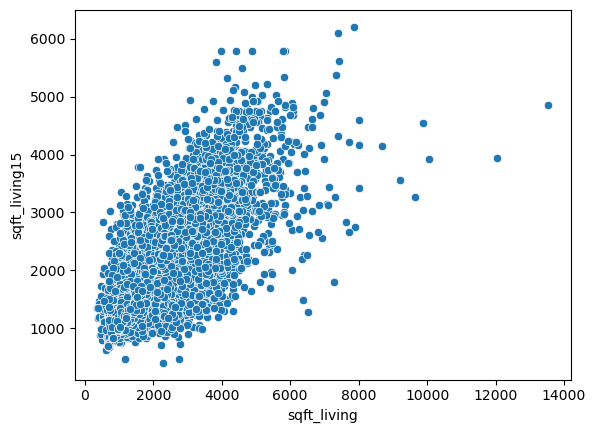

In [170]:
sqft_above = dataset['sqft_above']
sqft_basement = dataset['sqft_basement']
sqft_living = sqft_above + sqft_basement
dataset.loc[dataset['sqft_living'].isnull(),'sqft_living']=sqft_living

sns.scatterplot(data=dataset, x="sqft_living", y="sqft_living15")

#### Fill in missing values in the bedrooms column

In [171]:
#check which value correlates most (sqft_living)
#dataset.corr()
#sns.scatterplot(data=dataset, x="bedrooms", y="sqft_living")


#after viewing the scatterplot, can be seen that the relationship is not quite linear.
#updated to median
bedrooms_avg = dataset['bedrooms'].median()
dataset.loc[dataset['bedrooms'].isnull(),'bedrooms']=bedrooms_avg


#### Fill in missing values in the sqft_lot category

<AxesSubplot:xlabel='sqft_lot15', ylabel='sqft_lot'>

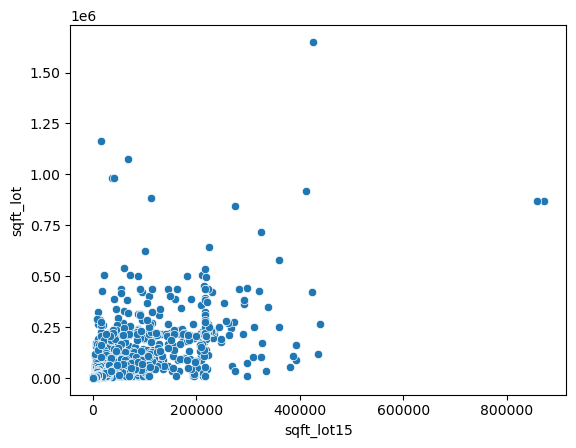

In [174]:
#even though high correlation coefficient, no clear relationship. therefore, also using averages.

sqft_lot_avg = dataset['sqft_lot'].median()
dataset.loc[dataset['sqft_lot'].isnull(),'sqft_lot']=sqft_lot_avg

sns.scatterplot(data=dataset, x="sqft_lot15", y="sqft_lot")
#new pattern popped out showing something for 15,000

#### Fill in missing values in the bathrooms column

<AxesSubplot:xlabel='bathrooms', ylabel='sqft_living'>

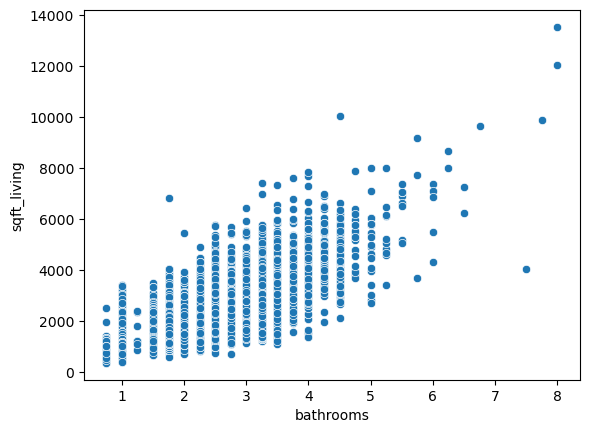

In [175]:
#updated to median
bathrooms_avg = dataset['bathrooms'].median()
dataset.loc[dataset['bathrooms'].isnull(),'bathrooms']=bathrooms_avg

sns.scatterplot(data=dataset, x="bathrooms", y="sqft_living")

#### Removing outliers 
* After doing df.describe(), we can see that the biggest outliers are in the bedroom, sqft_lot, and sqft_living categories

In [176]:
#highest bedroom value was 33. After further investigation, looks like data entry mistake. fill with avg
dataset['bedrooms'] = dataset['bedrooms'].replace([33],bedrooms_avg)


<AxesSubplot:title={'center':'Distribution of Sqft_Living'}, xlabel='sqft_living', ylabel='Density'>

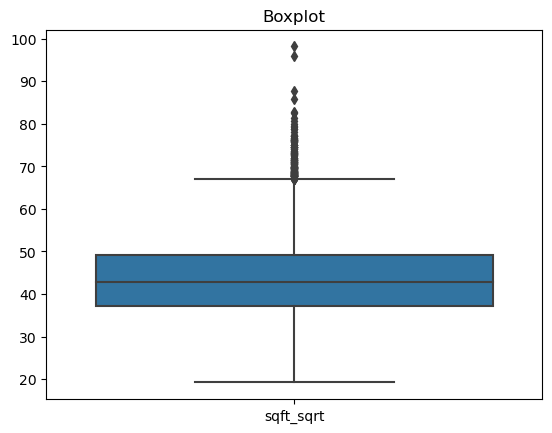

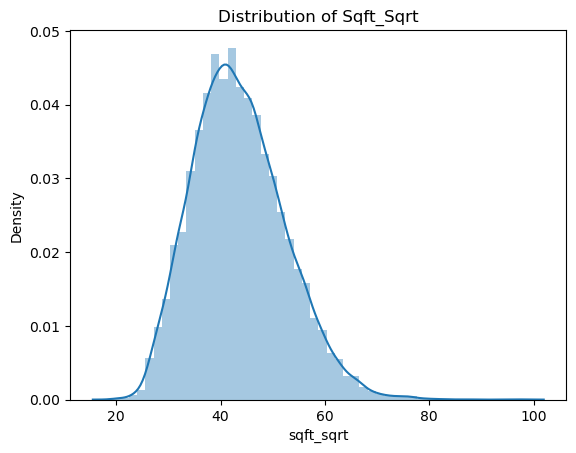

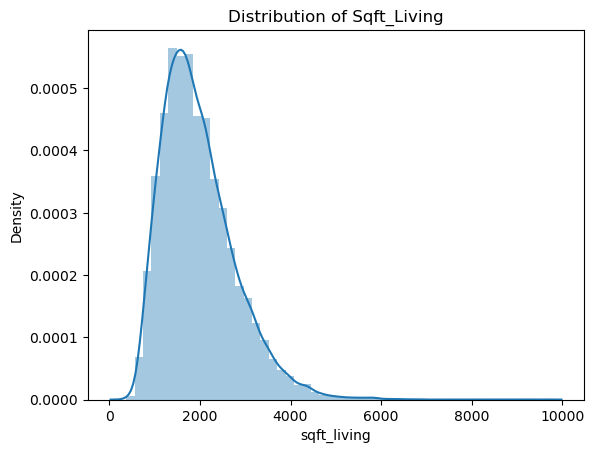

In [180]:
#removed outliers with large sqft_lots
q1 = dataset['sqft_lot'].quantile(.25)
q2 = dataset['sqft_lot'].quantile(.5)
q3 = dataset['sqft_lot'].quantile(.75)
q4 = dataset['sqft_lot'].quantile(.1)
iqr = q3 - q1

#instead of doing standard 1.5iqr, did 1.65 so we did not lose too much data
#upperlimit = q3 + (1.65*iqr)
#lowerlimit = q1 - (1.65*iqr)

#tested with 1.5
upperlimit = q3 + (1.5*iqr)
lowerlimit = q1 - (1.5*iqr)

dataset = dataset[dataset['sqft_lot']<upperlimit]
#lowerlimit is less than zero so don't need to filter because no occurence of negative values

dataset['sqft_sqrt'] = np.sqrt(dataset['sqft_living'])

plt.figure(1)
plt.title('Boxplot')
sns.boxplot(data = dataset[['sqft_sqrt']])

plt.figure(2)
plt.title('Distribution of Sqft_Sqrt')
sns.distplot(dataset['sqft_sqrt'])

plt.figure(3)
plt.title('Distribution of Sqft_Living')
sns.distplot(dataset['sqft_living'])


<AxesSubplot:title={'center':'Boxplot'}>

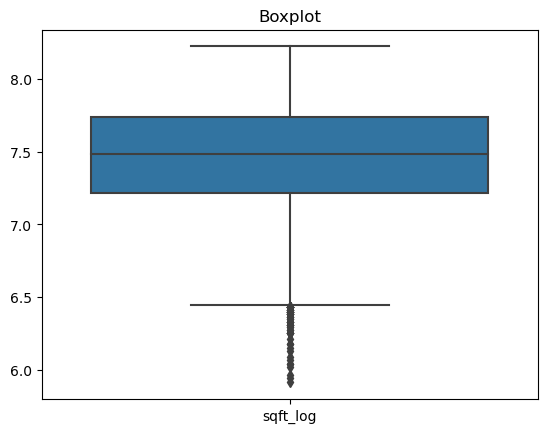

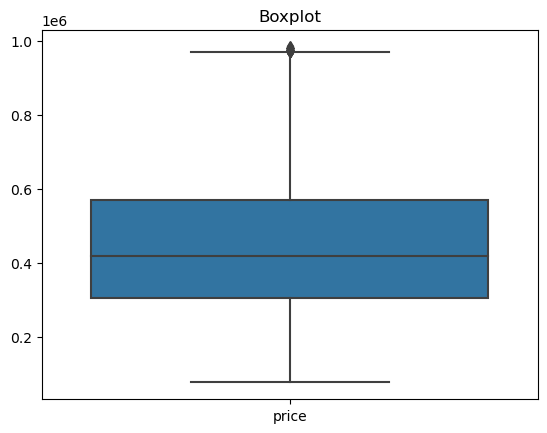

In [154]:
#removed outliers in sqft_living after log transformation
q1 = dataset['sqft_living'].quantile(.25)
q2 = dataset['sqft_living'].quantile(.5)
q3 = dataset['sqft_living'].quantile(.75)
q4 = dataset['sqft_living'].quantile(.1)

#iqr = q3 - q1

#instead of doing standard 1.5iqr, did 1.65 so we did not lose too much data
#upperlimit = q3 + (1.6*iqr)
#lowerlimit = q1 - (1.6*iqr)

#tested with 1.5
#upperlimit = q3 + (1.5*iqr)
#upperlimit
#lowerlimit = q1 - (1.5*iqr)
#lowerlimit

#dataset['price_sqrt'] = np.sqrt(dataset['price'])


#dataset = dataset[dataset['sqft_living']<upperlimit]
#sns.scatterplot(data=dataset, x="sqft_living", y="sqft_log")

<AxesSubplot:title={'center':'Distribution of Price'}, xlabel='price', ylabel='Density'>

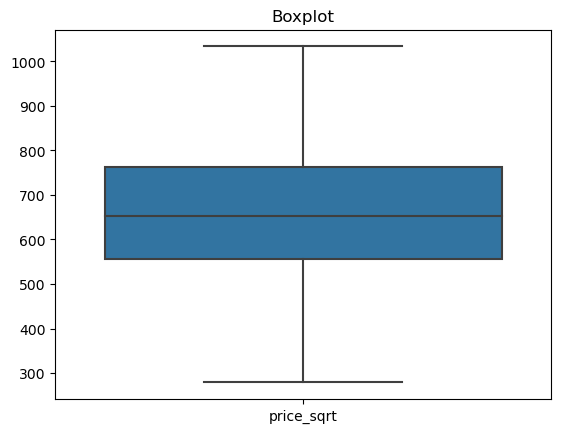

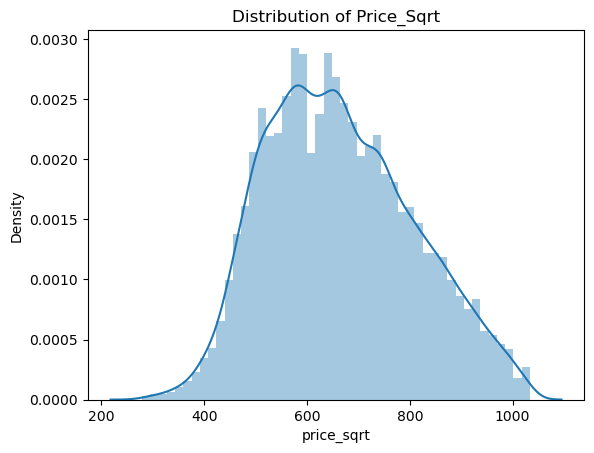

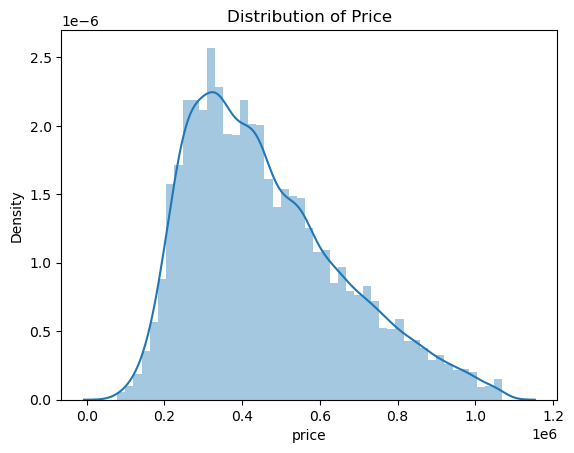

In [181]:
#removed outliers in price
q1 = dataset['price'].quantile(.25)
q2 = dataset['price'].quantile(.5)
q3 = dataset['price'].quantile(.75)
q4 = dataset['price'].quantile(.1)

iqr = q3 - q1

#instead of doing standard 1.5iqr, did 1.65 so we did not lose too much data
#upperlimit = q3 + (1.6*iqr)
#lowerlimit = q1 - (1.6*iqr)

#tested with 1.5
upperlimit = q3 + (1.5*iqr)
lowerlimit = q1 - (1.5*iqr)


dataset = dataset[dataset['price']<upperlimit]

dataset['price_sqrt'] = np.sqrt(dataset['price'])

plt.figure(1)
plt.title('Boxplot')
sns.boxplot(data = dataset[['price_sqrt']])

plt.figure(2)
plt.title('Distribution of Price_Sqrt')
sns.distplot(dataset['price_sqrt'])

plt.figure(3)
plt.title('Distribution of Price')
sns.distplot(dataset['price'])


### Drop redundant data

In [182]:
# To ignore the warning message
warnings.filterwarnings('ignore')

#dropping the earliest entry of each duplicate ID 
dataset.sort_values(by=['id', 'date'], inplace=True)
#keeping the entry with the most recent date
dataset = dataset.drop_duplicates(subset=['id'], keep='last')
#houses.drop(['id'], axis=1, inplace = True)

### Feature Construction and Discretization

#### Add columns for year sold and month sold

In [183]:
dataset['yr_sold'] = pd.DatetimeIndex(dataset['date']).year
dataset['month_sold'] = pd.DatetimeIndex(dataset['date']).month

**Add column to change year renovated to binary variable**

In [261]:
#update dataset to Yes/No for renovated
dataset["renovate"] = pd.cut(dataset["yr_renovated"],2,labels = ['No','Yes'])

In [83]:
#update year built to age
#import datetime
#t1 = dataset['yr_sold']
#t2 = dataset['yr_built']
#house_age = t1 - t2
#dataset['house_age'] = house_age

#### Generate Categories for lat, long, and latitude + longitude

[Text(0, 0, 'south-midwest'),
 Text(1, 0, 'central-midwest'),
 Text(2, 0, 'central-west'),
 Text(3, 0, 'north-west'),
 Text(4, 0, 'north-midwest'),
 Text(5, 0, 'south-west'),
 Text(6, 0, 'north-central'),
 Text(7, 0, 'central-central'),
 Text(8, 0, 'central-east'),
 Text(9, 0, 'south-central'),
 Text(10, 0, 'north-east'),
 Text(11, 0, 'central-mideast')]

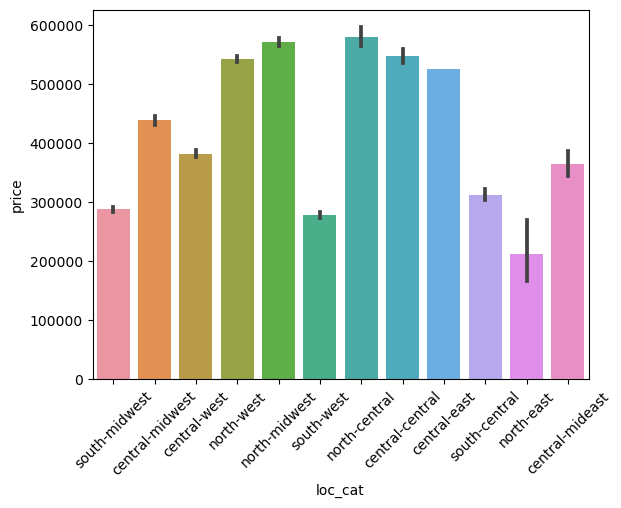

In [185]:
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

dataset['long_cat'] = pd.cut(dataset['long'],5,labels = ['west', 'midwest', 'central', 'mideast', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)

location_category = dataset['loc_cat']
price = dataset['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

[Text(0, 0, 'south-west'),
 Text(1, 0, 'central-west'),
 Text(2, 0, 'north-west'),
 Text(3, 0, 'north-central'),
 Text(4, 0, 'south-central'),
 Text(5, 0, 'central-central'),
 Text(6, 0, 'central-east'),
 Text(7, 0, 'north-east')]

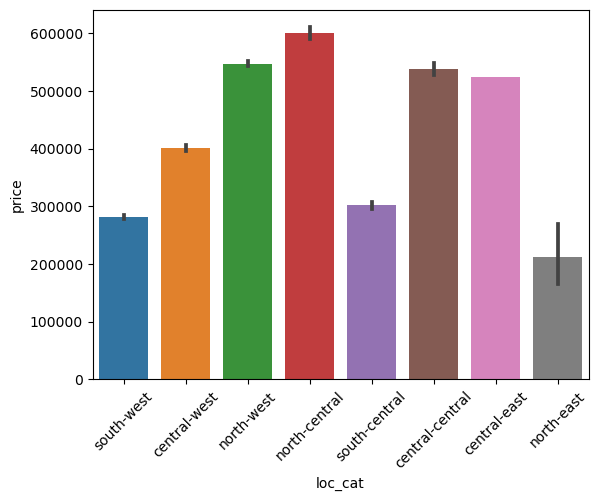

In [186]:
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

dataset['long_cat'] = pd.cut(dataset['long'],3,labels = ['west', 'central', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)


location_category = dataset['loc_cat']
price = dataset['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

### Test only lattitude. 

[Text(0, 0, 'south'), Text(1, 0, 'central'), Text(2, 0, 'north')]

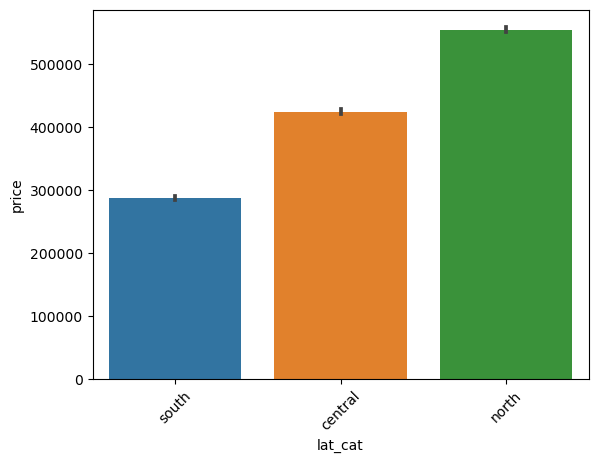

In [187]:
location_category = dataset['lat_cat']
price = dataset['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

### Test only longitude.

[Text(0, 0, 'west'), Text(1, 0, 'central'), Text(2, 0, 'east')]

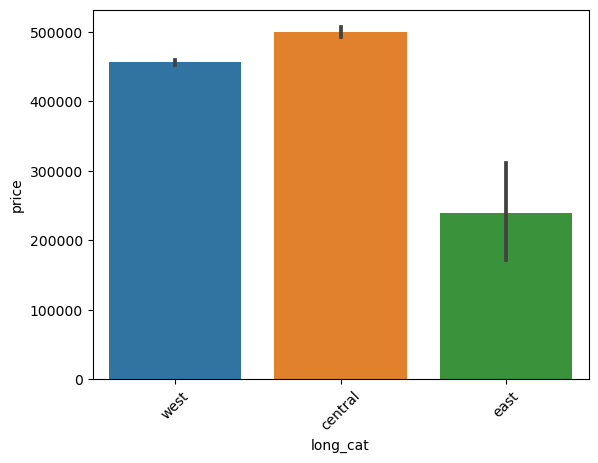

In [188]:
location_category = dataset['long_cat']
price = dataset['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

### Longitude as 2 categories. 

[Text(0, 0, 'west'), Text(1, 0, 'east')]

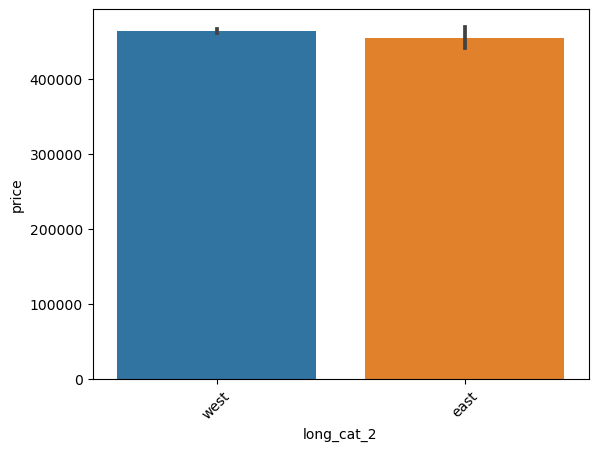

In [189]:
dataset['long_cat_2'] = pd.cut(dataset['long'],2,labels = ['west', 'east'])
dataset.head()

location_category = dataset['long_cat_2']
price = dataset['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')



## 3. Exploratory Data Analysis and Visualization

* Identify categorical, ordinal, and numerical variables within the data
* Provide measures of centrality and distribution with visualizations
* Diagnose for correlations between variables and determine independent and dependent variables
* Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest

In [190]:
# Identify categorical, ordinal, and numerical variables within the original data
numerical_variables = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 
                      'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']
ordinal_variables = ['condition', 'grade']
categorical_variables = ['date', 'waterfront', 'view', 'zipcode', 'lat', 'long']


discrete_vars = ['price', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade',
                 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_living15']



In [191]:
#updated lists of variables

num_vars_update = ['price_sqrt', 'bedrooms', 'bathrooms', 'sqft_sqrt', 
                       'floors', 'condition', 'grade', 'yr_built']

cat_var_update = ['lat_cat', 'long_cat', 'loc_cat', 'yr_sold', 'month_sold', 'renovate']


### Statistical and Correlation Analysis

From the statistical analysis table and the correlation heatmap, we see:
* some redundant variables, such as 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', they can be removed.
* The house with 33 bedrooms should be treated as outlier. Therefore, it can be removed.

In [192]:
numerical_subset_1 = dataset[numerical_variables]

In [193]:
# Find the statistics for the numerical variables
round(numerical_subset_1.describe(), 2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00
mean,463777.34,3.29,2.02,1897.22,6894.21,1.48,3.41,7.46,1639.52,257.70,1970.23,71.48,1853.68,7145.64
std,197934.95,0.86,0.70,717.97,2932.02,0.54,0.65,0.96,676.34,390.52,30.20,370.86,574.56,6039.56
min,78000.00,1.00,0.75,370.00,520.00,1.00,1.00,3.00,370.00,0.00,1900.00,0.00,460.00,651.00
25%,310000.00,3.00,1.50,1360.00,4860.00,1.00,3.00,7.00,1140.00,0.00,1950.00,0.00,1440.00,4851.00
50%,425000.00,3.00,2.00,1790.00,7200.00,1.00,3.00,7.00,1460.00,0.00,1972.00,0.00,1740.00,7110.00
75%,585000.00,4.00,2.50,2330.00,8707.00,2.00,4.00,8.00,1990.00,500.00,1998.00,0.00,2170.00,8705.50
max,1068000.00,10.00,7.50,5820.00,14568.00,3.50,5.00,12.00,5370.00,2170.00,2015.00,2015.00,4950.00,297514.00


In [194]:
# Find correlation coefficients of among the numerical variables
round(numerical_subset_1.corr(), 2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
price,1.00,0.28,0.42,0.59,-0.03,0.26,0.04,0.60,0.49,0.24,0.01,0.09,0.52,-0.01
bedrooms,0.28,1.00,0.49,0.61,0.21,0.15,0.01,0.32,0.49,0.28,0.17,0.01,0.39,0.08
bathrooms,0.42,0.49,1.00,0.71,-0.03,0.52,-0.15,0.60,0.63,0.21,0.55,0.03,0.53,-0.00
sqft_living,0.59,0.61,0.71,1.00,0.21,0.34,-0.08,0.68,0.84,0.38,0.35,0.02,0.74,0.12
sqft_lot,-0.03,0.21,-0.03,0.21,1.00,-0.37,0.13,0.04,0.16,0.10,-0.05,-0.01,0.24,0.44
floors,0.26,0.15,0.52,0.34,-0.37,1.00,-0.29,0.48,0.54,-0.30,0.52,-0.00,0.28,-0.18
condition,0.04,0.01,-0.15,-0.08,0.13,-0.29,1.00,-0.19,-0.20,0.19,-0.37,-0.06,-0.13,0.07
grade,0.60,0.32,0.60,0.68,0.04,0.48,-0.19,1.00,0.68,0.06,0.50,-0.01,0.65,0.04
sqft_above,0.49,0.49,0.63,0.84,0.16,0.54,-0.20,0.68,1.00,-0.18,0.47,-0.01,0.72,0.10
sqft_basement,0.24,0.28,0.21,0.38,0.10,-0.30,0.19,0.06,-0.18,1.00,-0.17,0.05,0.11,0.04


<AxesSubplot:title={'center':'Heat Map of Correlation Coefficients'}>

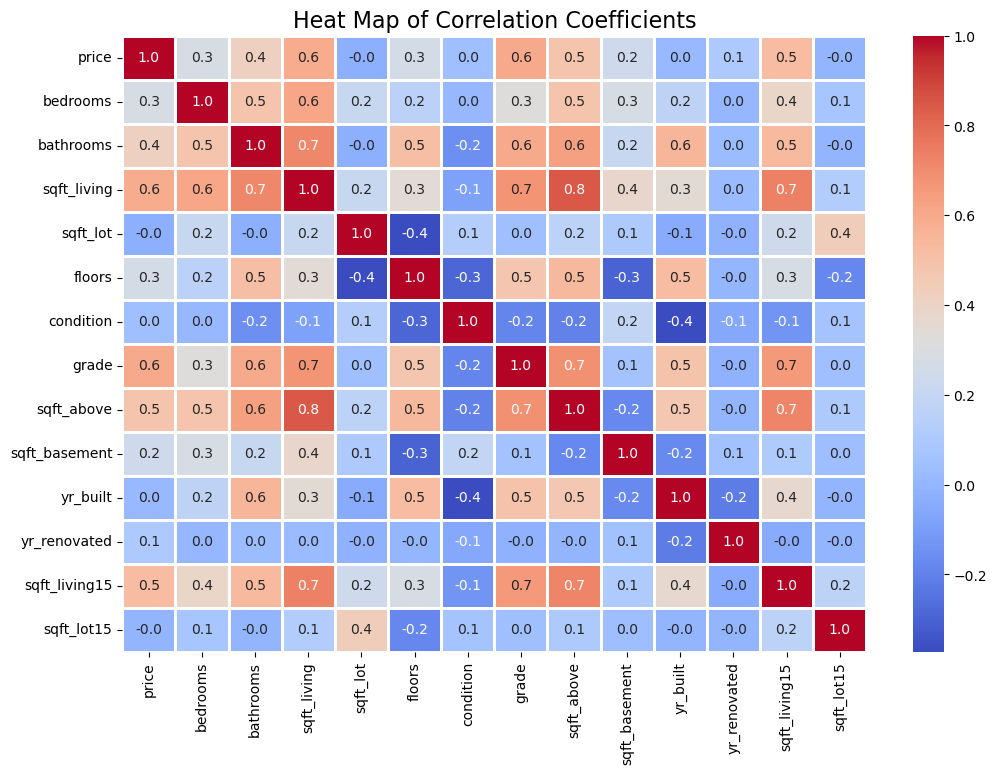

In [195]:
# Heatmap for correlations from original data
plt.figure(figsize=(12, 8))
plt.title("Heat Map of Correlation Coefficients", fontsize=16)
sns.heatmap(numerical_subset_1.corr(), cmap = 'coolwarm', fmt = '.1f', linewidths = 1, annot = True)

## **Update variables and redo matrix**

### Adding New Columns

In [196]:
# Add two new columns 'price_per_sqft' and 'price_log' to facilitate analysis
#houses['price_per_sqft'] = houses['price'] / houses['sqft_living']
#numerical_subset['price_per_sqft'] = houses['price'] / houses['sqft_living']
#numerical_subset['price_log'] = np.log(houses['price'])
#houses.head()

In [197]:
# Subset numerical fields
numerical_subset_2 = dataset[num_vars_update]

In [198]:
# Find the statistics for the numerical variables
round(numerical_subset_2.describe(), 2)

,price_sqrt,bedrooms,bathrooms,sqft_sqrt,floors,condition,grade,yr_built
count,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00,16555.00
mean,665.87,3.29,2.02,42.80,1.48,3.41,7.46,1970.23
std,142.79,0.86,0.70,8.11,0.54,0.65,0.96,30.20
min,279.28,1.00,0.75,19.24,1.00,1.00,3.00,1900.00
25%,556.78,3.00,1.50,36.88,1.00,3.00,7.00,1950.00
50%,651.92,3.00,2.00,42.31,1.00,3.00,7.00,1972.00
75%,764.85,4.00,2.50,48.27,2.00,4.00,8.00,1998.00
max,1033.44,10.00,7.50,76.29,3.50,5.00,12.00,2015.00


In [199]:
# Find correlation coefficients of among the numerical variables
round(numerical_subset_2.corr(), 2)

,price_sqrt,bedrooms,bathrooms,sqft_sqrt,floors,condition,grade,yr_built
price_sqrt,1.00,0.28,0.43,0.58,0.27,0.04,0.60,0.02
bedrooms,0.28,1.00,0.49,0.63,0.15,0.01,0.32,0.17
bathrooms,0.43,0.49,1.00,0.72,0.52,-0.15,0.60,0.55
sqft_sqrt,0.58,0.63,0.72,1.00,0.35,-0.08,0.68,0.36
floors,0.27,0.15,0.52,0.35,1.00,-0.29,0.48,0.52
condition,0.04,0.01,-0.15,-0.08,-0.29,1.00,-0.19,-0.37
grade,0.60,0.32,0.60,0.68,0.48,-0.19,1.00,0.50
yr_built,0.02,0.17,0.55,0.36,0.52,-0.37,0.50,1.00


<AxesSubplot:title={'center':'Heat Map of Correlation Coefficients'}>

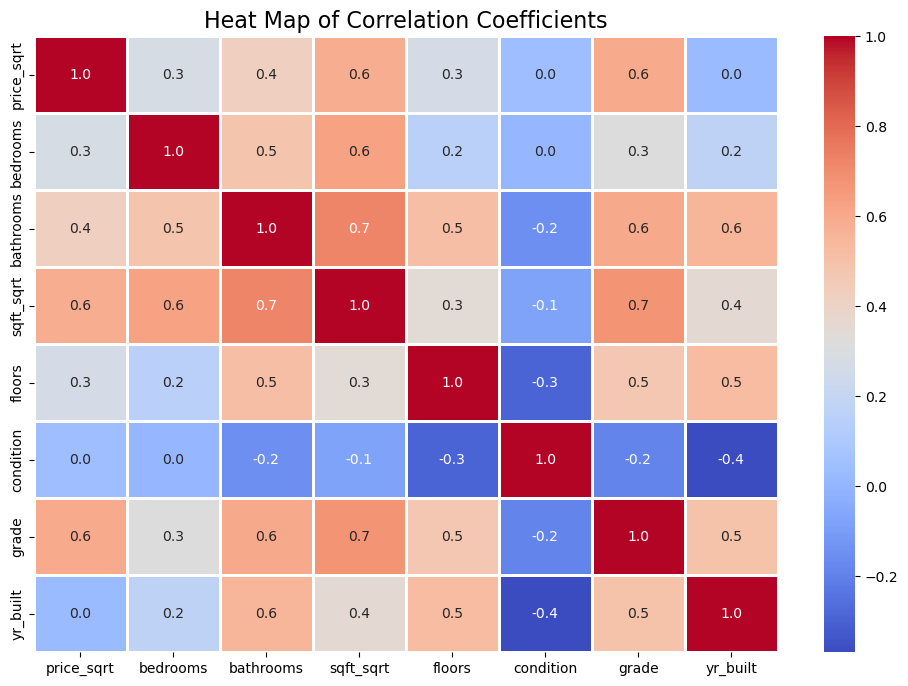

In [200]:
# Heatmap for correlations
plt.figure(figsize=(12, 8))
plt.title("Heat Map of Correlation Coefficients", fontsize=16)
sns.heatmap(numerical_subset_2.corr(), cmap = 'coolwarm', fmt = '.1f', linewidths = 1, annot = True)

### Data Wrangling (Will be merged or replaced)

In [201]:
# Remove some redundant variables
#warnings.filterwarnings('ignore')
#dataset.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1, inplace = True)
#numerical_subset.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1, inplace = True)

# Drop the outlier with the extreme number of bedrooms.tagged this out because we 
#already changed it to 3
#dataset.drop(dataset[dataset.bedrooms > 20].index, inplace = True)
#dataset.head()

### Redo Correlation Analysis

### Histogram Distribution of the Dependent Variable

In [99]:
# Separate Prices into a new variable
prices = dataset['price']

# Define column lists for plotting
bar_cols = ['view', 'waterfront', 'condition', 'grade', 'bedrooms', 'bathrooms']
scatter_cols = ['yr_built', 'yr_renovated', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade', 'floors']
pair_cols = ['sqft_living', 'sqft_lot', 'grade', 'condition']

<AxesSubplot:title={'center':'Distribution of Price Log'}, xlabel='price_log'>

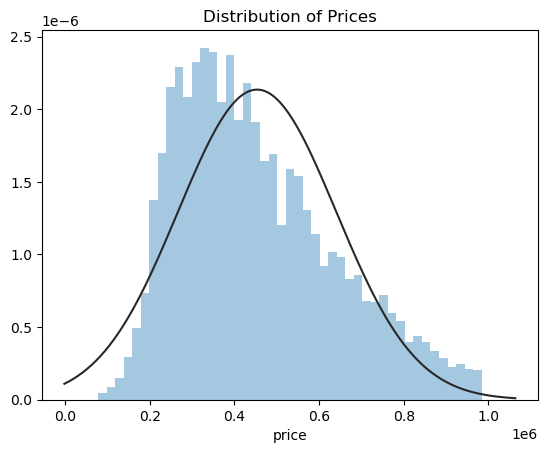

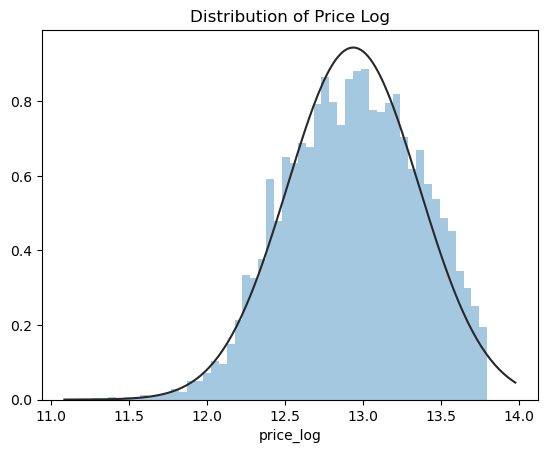

In [100]:
# Display Histogram for Prices
plt.figure(1)
plt.title('Distribution of Prices')
sns.distplot(prices, kde=False, fit=stats.norm)

plt.figure(2)
plt.title('Distribution of Price Log')
sns.distplot(dataset['price_log'], kde=False, fit=stats.norm)

<AxesSubplot:title={'center':'Distribution of Sqft_Lot'}, xlabel='sqft_lot'>

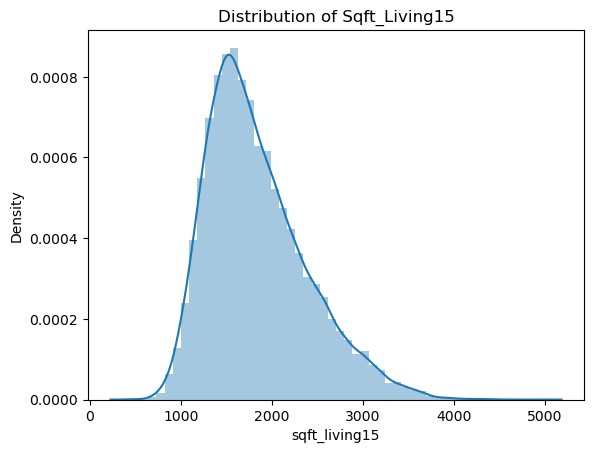

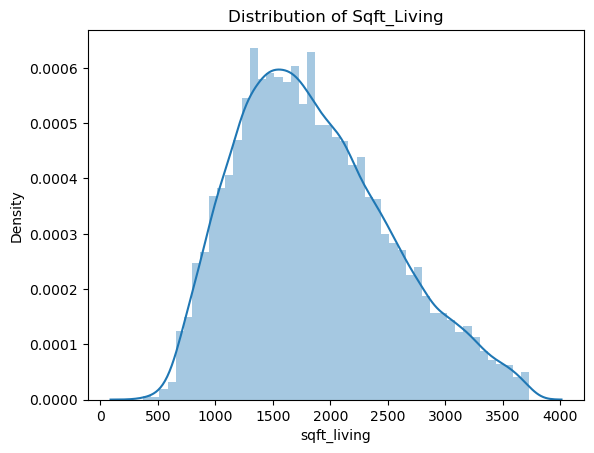

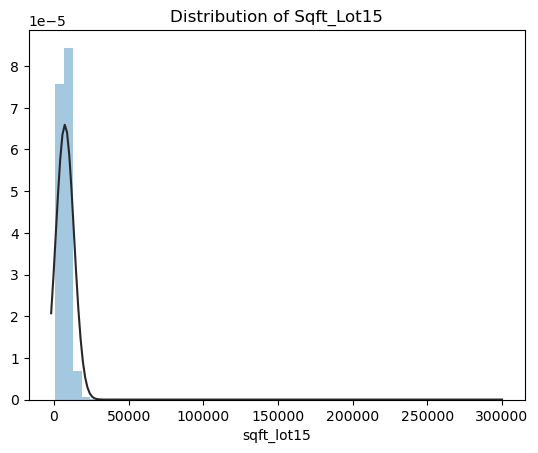

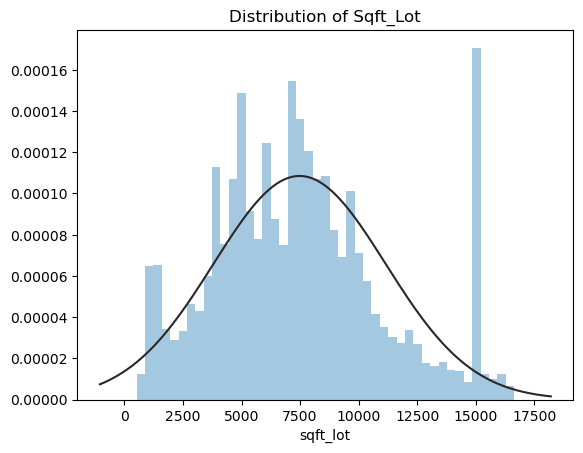

In [129]:
plt.figure(1)
plt.title('Distribution of Sqft_Living15')
sns.distplot(dataset['sqft_living15'])

plt.figure(2)
plt.title('Distribution of Sqft_Living')
sns.distplot(dataset['sqft_living'])

plt.figure(3)
plt.title('Distribution of Sqft_Lot15')
sns.distplot(dataset['sqft_lot15'], kde=False, fit=stats.norm)

plt.figure(4)
plt.title('Distribution of Sqft_Lot')
sns.distplot(dataset['sqft_lot'], kde=False, fit=stats.norm)

### Distribution Analysis with Box Plot

<AxesSubplot:title={'center':'Boxplots'}>

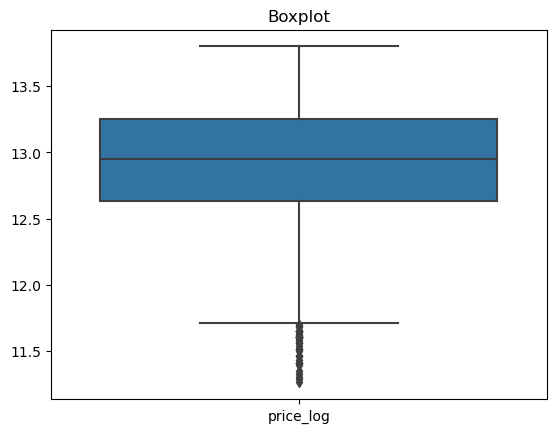

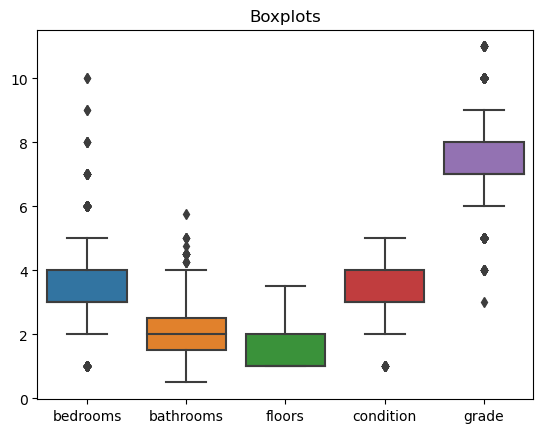

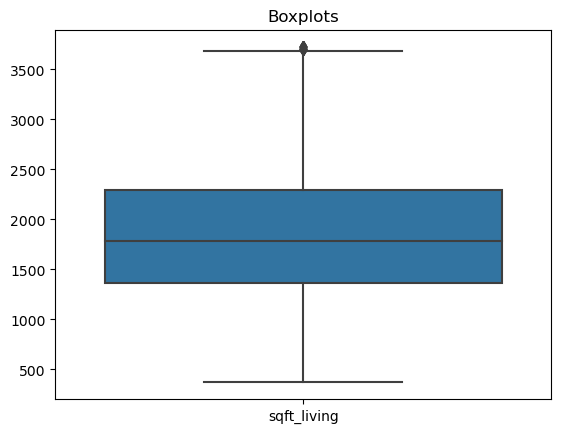

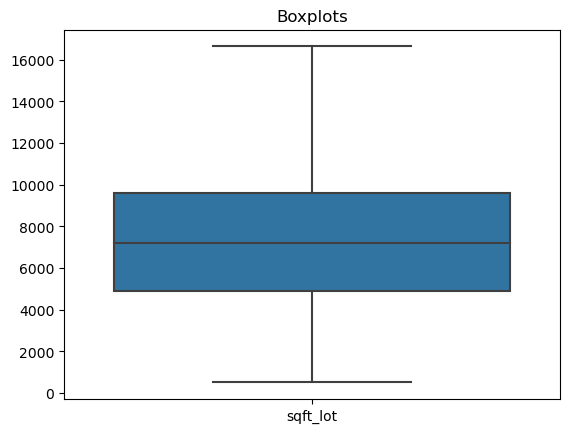

In [101]:
# Create box plots

plt.figure(1)
plt.title('Boxplot')
sns.boxplot(data = dataset[['price_log']])

plt.figure(2)
plt.title('Boxplots')
sns.boxplot(data = dataset[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade']])

plt.figure(3)
plt.title('Boxplots')
sns.boxplot(data = dataset[['sqft_living']])

plt.figure(4)
plt.title('Boxplots')
sns.boxplot(data = dataset[['sqft_lot']])

### Bar Plots for Categorical and Discrete Variables

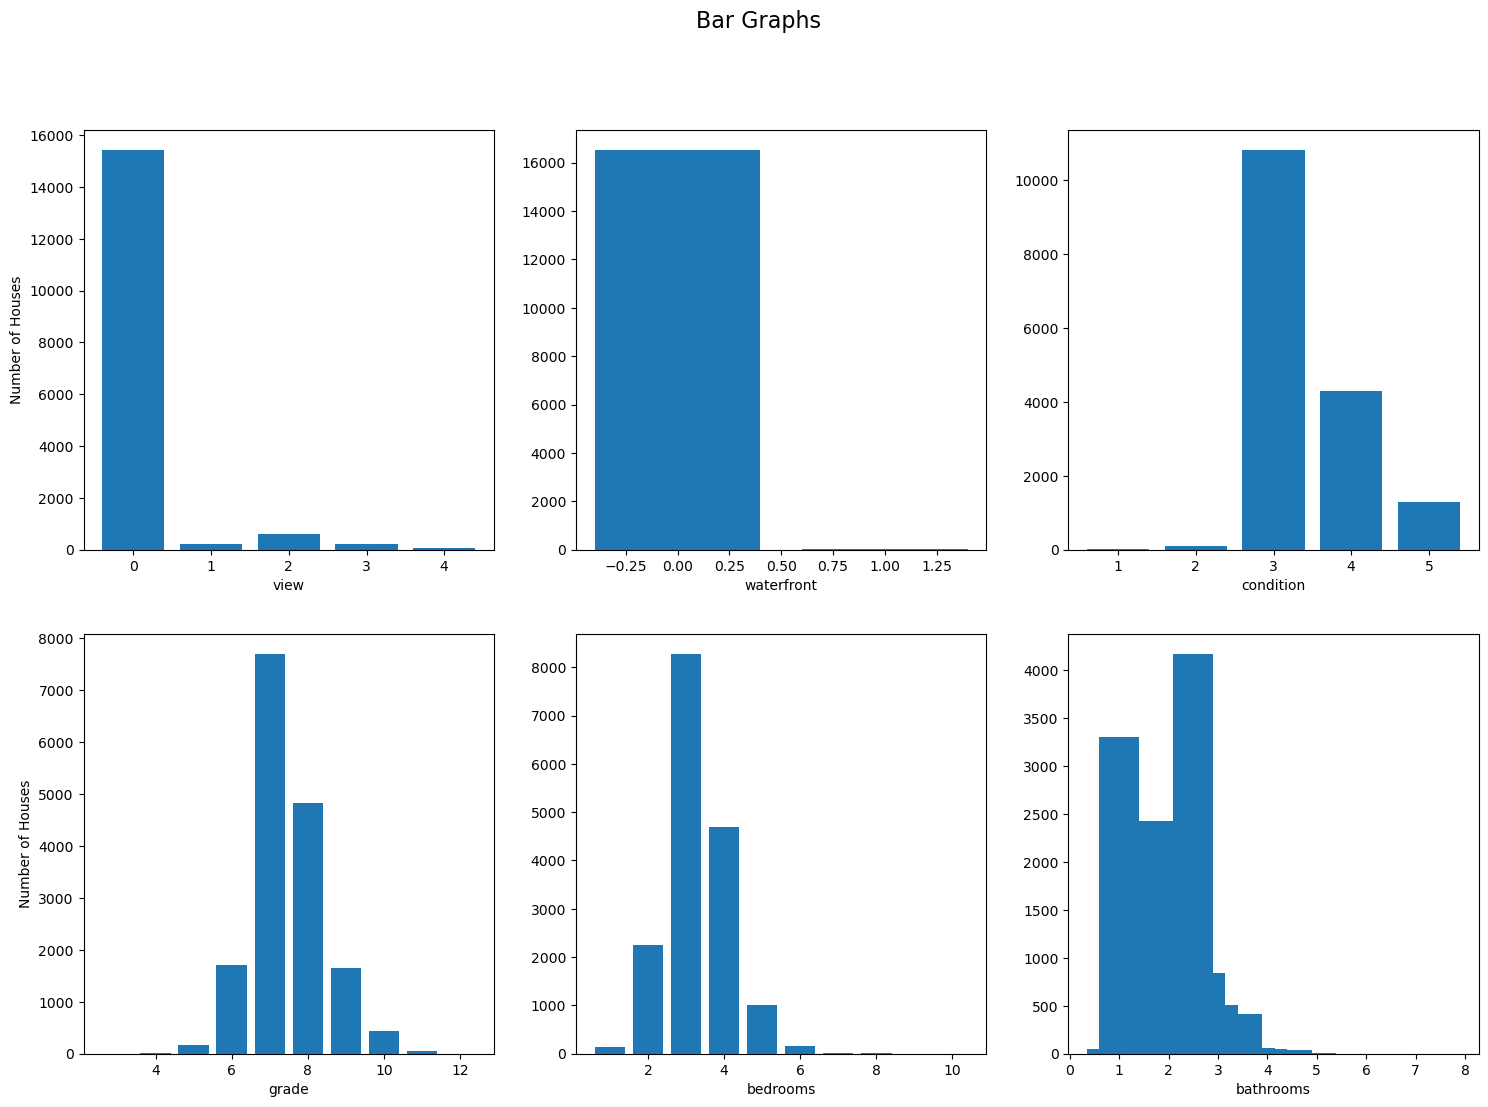

In [202]:
# Create bar plots
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.suptitle("Bar Graphs",fontsize=16)

for n in range(len(bar_cols)):
    i = 0 if n < 3 else 1  
    j = n % 3;
    values = dataset[bar_cols[n]].value_counts()
    pd.Series.sort_index(values, inplace=True)
    indexes = list(values.index)
    axes[i][j].bar(indexes, values)
    axes[i][j].set_xlabel(bar_cols[n])
    
axes[0][0].set_ylabel("Number of Houses")
axes[1][0].set_ylabel("Number of Houses")

plt.show()

Text(0.5, 1.0, 'House Distribution by Zipcode')

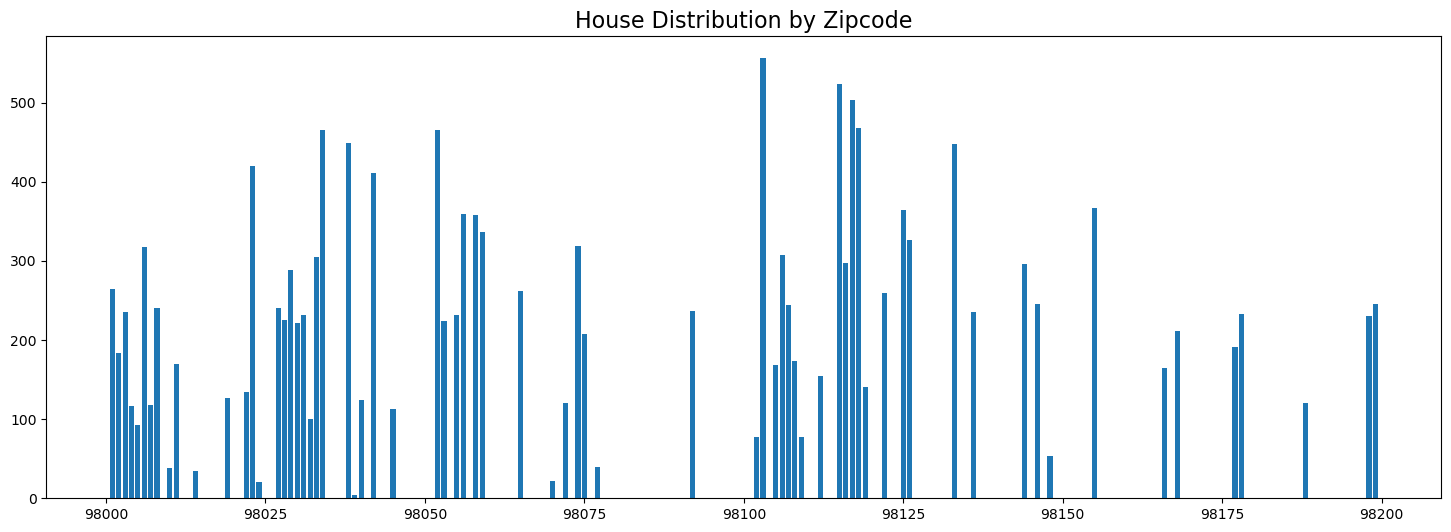

In [203]:
plt.figure(figsize = (18, 6))
values = dataset['zipcode'].value_counts()
pd.Series.sort_index(values, inplace=True)
indexes = list(values.index)
plt.bar(indexes, values)
plt.title("House Distribution by Zipcode", fontsize = 16)

### Scatter Plots for Numerical Variables vs. Price

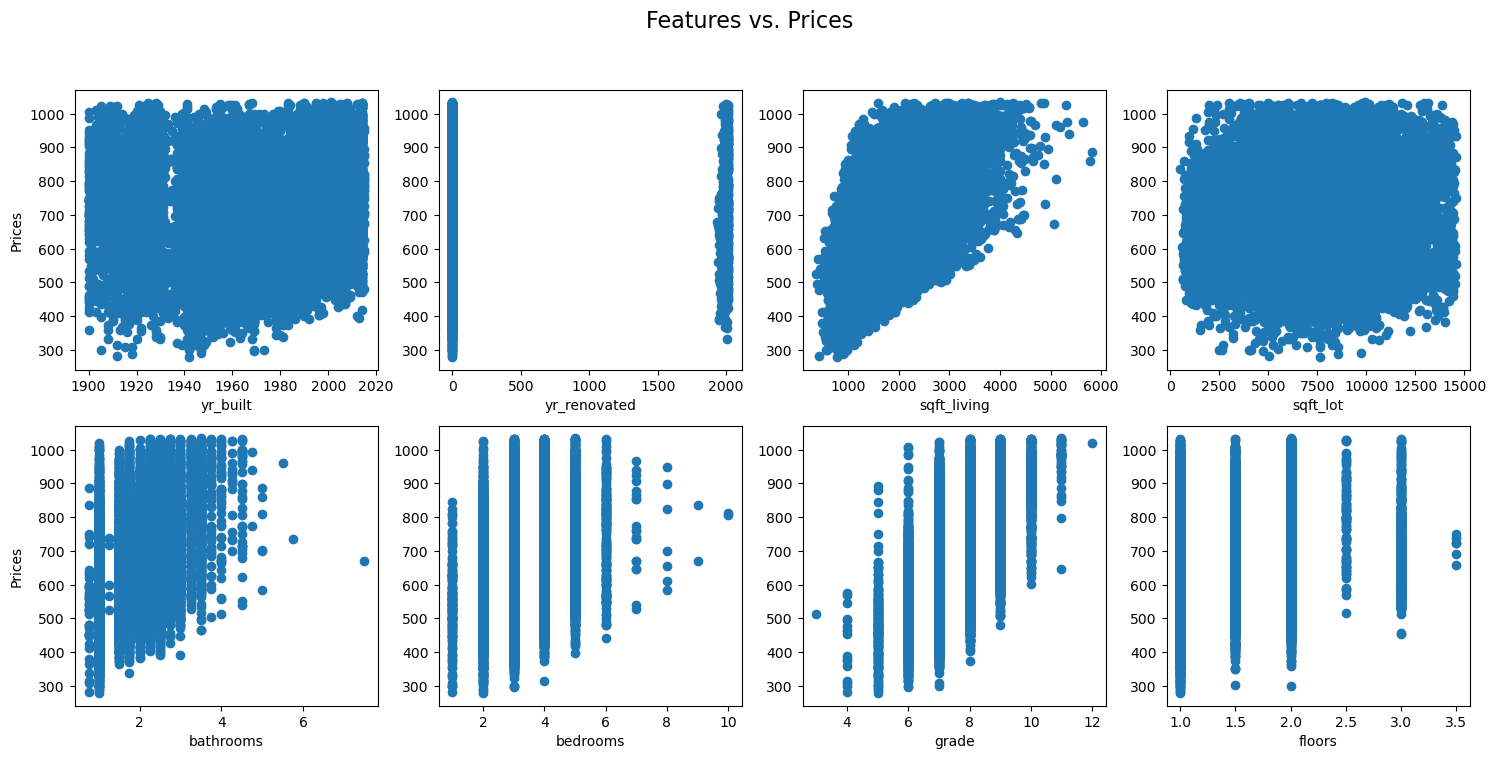

In [204]:
#Create scatter plots
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(18,8))
fig.suptitle("Features vs. Prices",fontsize=16)

for n in range(len(scatter_cols)):
    i = 0 if n < 4 else 1  
    j = n % 4;
    axes[i][j].scatter(dataset[scatter_cols[n]], dataset['price_sqrt'])
    axes[i][j].set_xlabel(scatter_cols[n])
    
axes[0][0].set_ylabel("Prices")
axes[1][0].set_ylabel("Prices")

plt.show()

### Joint Plot to show Distribution by Latiture and Longitude

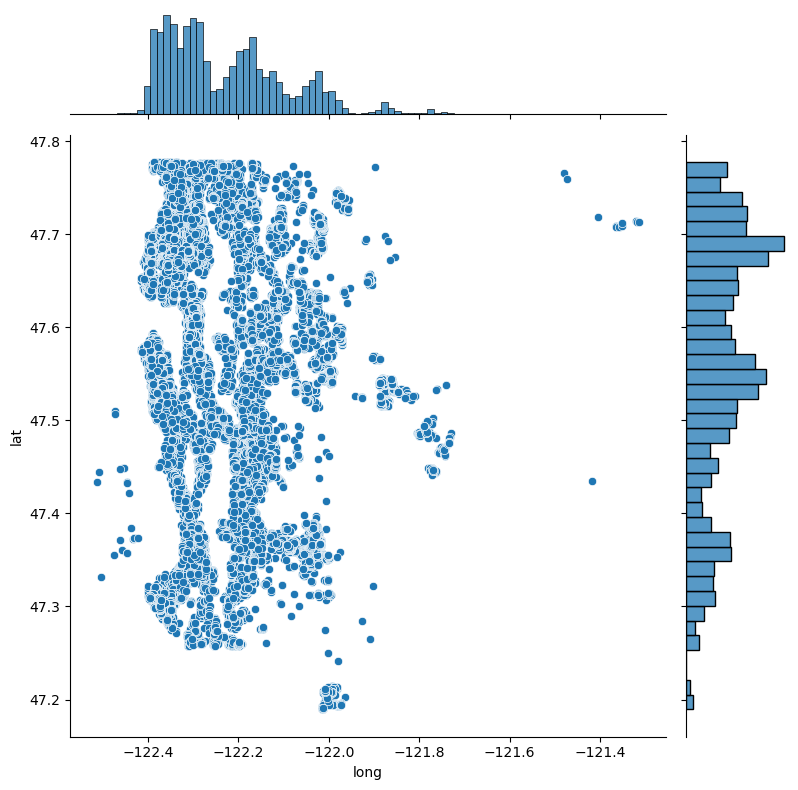

In [206]:
#flipped the lat and long to reperesent map -v 11/19/2022
sns.jointplot(dataset['long'], dataset['lat'], size= 8)


#east locations are "location" outliers 

# Ordinal Correlation & Tests of Association (categorical)

Spearmans Rank Correlation Coefficient

In [208]:
#measure of collinearity for ordinal variables
data_ord = pd.DataFrame(dataset[ordinal_variables])

scc_1, p = spearmanr(data_ord['condition'],data_ord['grade'])
print('scc_1, p = %.3f' % scc_1)


#weak negative correlation between each other

scc_1, p = -0.204


### Convert 'price_sqrt' into categorical bins for x2 testing. Bins = 6 (3 SD on each side)

In [213]:
#cut dataset into 6 bins for price_log
dataset['price_sqrt_cat'] = pd.cut(dataset['price_sqrt'], 6)
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_sqrt,price_sqrt,yr_sold,month_sold,renovate,lat_cat,long_cat,loc_cat,long_cat_2,price_sqrt_cat
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,48.989795,547.722558,2015,4,No,south,west,south-west,west,"(530.67, 656.363]"
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,37.815341,484.767986,2015,4,No,central,west,central-west,west,"(404.977, 530.67]"
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,47.116876,824.621125,2015,3,No,central,west,central-west,west,"(782.056, 907.748]"
21063,5200087,2014-07-09,487000.0,4.0,2.50,2540.0,5001.0,2.0,0,0,...,50.398413,697.853853,2014,7,No,central,west,central-west,west,"(656.363, 782.056]"
16815,7200179,2015-04-24,175000.0,2.0,1.00,840.0,12750.0,1.0,0,0,...,28.982753,418.330013,2015,4,No,central,west,central-west,west,"(404.977, 530.67]"


### Price and lattitude location.

In [227]:
#chisq_freq_1_a = pd.crosstab(dataset['price_sqrt_cat'], 
                           #dataset['loc_cat'], 
                           #margins=True, margins_name='Total')
#chisq_freq_1_a

#run test
#stats.chi2_contingency(chisq_freq_1_a)

#not valid


chisq_freq_1_b = pd.crosstab(dataset['price_sqrt_cat'], 
                           dataset['lat_cat'], 
                           margins=True, margins_name='Total')
chisq_freq_1_b

#run test
stats.chi2_contingency(chisq_freq_1_b)

#stat sig, but df and x2 are far apart


(5347.4491192515625,
 0.0,
 18,
 array([[   37.06372697,    82.07260646,   106.86366657,   226.        ],
        [  483.79643612,  1071.30172153,  1394.90184234,  2950.        ],
        [  864.43763214,  1914.18012685,  2492.38224101,  5271.        ],
        [  730.28662036,  1617.12086983,  2105.59250982,  4453.        ],
        [  428.03684687,   947.82965871,  1234.13349441,  2610.        ],
        [  171.37873754,   379.49501661,   494.12624585,  1045.        ],
        [ 2715.        ,  6012.        ,  7828.        , 16555.        ]]))

### Price and renovation  status.

In [228]:
#create frequency table for price bins and renovation status
chisq_freq_2 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_2
stats.chi2_contingency(chisq_freq_2)

### valid relationship between renovation and price


(180.78291268242296,
 2.946913200579235e-32,
 12,
 array([[2.17904681e+02, 8.09531863e+00, 2.26000000e+02],
        [2.84433102e+03, 1.05668982e+02, 2.95000000e+03],
        [5.08219281e+03, 1.88807188e+02, 5.27100000e+03],
        [4.29349357e+03, 1.59506433e+02, 4.45300000e+03],
        [2.51650982e+03, 9.34901842e+01, 2.61000000e+03],
        [1.00756811e+03, 3.74318937e+01, 1.04500000e+03],
        [1.59620000e+04, 5.93000000e+02, 1.65550000e+04]]))

### Price and year.

In [230]:
chisq_freq_3 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['yr_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_3
stats.chi2_contingency(chisq_freq_3)

#not valid, no difference

(2.4998662785299435,
 0.9981624016608266,
 12,
 array([[  152.14557535,    73.85442465,   226.        ],
        [ 1985.97100574,   964.02899426,  2950.        ],
        [ 3548.49260042,  1722.50739958,  5271.        ],
        [ 2997.8064029 ,  1455.1935971 ,  4453.        ],
        [ 1757.0794322 ,   852.9205678 ,  2610.        ],
        [  703.50498339,   341.49501661,  1045.        ],
        [11145.        ,  5410.        , 16555.        ]]))

### Price and month.

In [231]:
chisq_freq_4 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_4
stats.chi2_contingency(chisq_freq_4)


#valid relationship between price and month

(105.06946140016768,
 0.006684643568361811,
 72,
 array([[1.00338266e+01, 1.34739958e+01, 1.97400181e+01, 2.38491090e+01,
         2.49412262e+01, 2.23747508e+01, 2.28662036e+01, 2.04225914e+01,
         1.84431290e+01, 1.96035035e+01, 1.49620054e+01, 1.52896406e+01,
         2.26000000e+02],
        [1.30972516e+02, 1.75877378e+02, 2.57668378e+02, 3.11304742e+02,
         3.25560254e+02, 2.92059801e+02, 2.98474781e+02, 2.66578073e+02,
         2.40739958e+02, 2.55886439e+02, 1.95300513e+02, 1.99577167e+02,
         2.95000000e+03],
        [2.34019027e+02, 3.14254123e+02, 4.60396617e+02, 5.56232981e+02,
         5.81704440e+02, 5.21846512e+02, 5.33308668e+02, 4.76316279e+02,
         4.30149260e+02, 4.57212685e+02, 3.48958985e+02, 3.56600423e+02,
         5.27100000e+03],
        [1.97701903e+02, 2.65485412e+02, 3.88948233e+02, 4.69911870e+02,
         4.91430444e+02, 4.40861794e+02, 4.50545153e+02, 4.02397342e+02,
         3.63394926e+02, 3.86258411e+02, 2.94804470e+02, 3.01260042e+0

## Check for Multicolinearity between Predictor Variables

### Change sqft_sqrt to categorical bins. 

In [233]:
#cut square foot living  into 6 bins
dataset['sqft_sqrt_cat'] = pd.cut(dataset['sqft_sqrt'], 6)

#check dataset
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,price_sqrt,yr_sold,month_sold,renovate,lat_cat,long_cat,loc_cat,long_cat_2,price_sqrt_cat,sqft_sqrt_cat
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,547.722558,2015,4,No,south,west,south-west,west,"(530.67, 656.363]","(47.762, 57.271]"
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,484.767986,2015,4,No,central,west,central-west,west,"(404.977, 530.67]","(28.744, 38.253]"
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,824.621125,2015,3,No,central,west,central-west,west,"(782.056, 907.748]","(38.253, 47.762]"
21063,5200087,2014-07-09,487000.0,4.0,2.50,2540.0,5001.0,2.0,0,0,...,697.853853,2014,7,No,central,west,central-west,west,"(656.363, 782.056]","(47.762, 57.271]"
16815,7200179,2015-04-24,175000.0,2.0,1.00,840.0,12750.0,1.0,0,0,...,418.330013,2015,4,No,central,west,central-west,west,"(404.977, 530.67]","(28.744, 38.253]"


### Square feet and lattitude location. 

In [240]:
#location and sqft_sqrt

chisq_freq_5 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['lat_cat'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_5
stats.chi2_contingency(chisq_freq_5)

#valid relationship

(192.1338285289374,
 3.72446110029191e-31,
 18,
 array([[7.93754153e+01, 1.75766113e+02, 2.28858472e+02, 4.84000000e+02],
        [7.61774388e+02, 1.68684627e+03, 2.19637934e+03, 4.64500000e+03],
        [1.15143552e+03, 2.54969810e+03, 3.31986638e+03, 7.02100000e+03],
        [5.98267593e+02, 1.32478260e+03, 1.72494980e+03, 3.64800000e+03],
        [1.18079130e+02, 2.61470251e+02, 3.40450619e+02, 7.20000000e+02],
        [6.06795530e+00, 1.34366657e+01, 1.74953790e+01, 3.70000000e+01],
        [2.71500000e+03, 6.01200000e+03, 7.82800000e+03, 1.65550000e+04]]))

### Square feet and month sold

In [245]:
#sqft_sqrt and month

chisq_freq_6 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_6
stats.chi2_contingency(chisq_freq_6)

#not valid

(48.48413150821314,
 0.9849479175600387,
 72,
 array([[2.14883721e+01, 2.88558140e+01, 4.22750831e+01, 5.10750831e+01,
         5.34139535e+01, 4.79176080e+01, 4.89700997e+01, 4.37368771e+01,
         3.94976744e+01, 4.19827243e+01, 3.20425249e+01, 3.27441860e+01,
         4.84000000e+02],
        [2.06226216e+02, 2.76932347e+02, 4.05718514e+02, 4.90173059e+02,
         5.12619450e+02, 4.59870432e+02, 4.69971308e+02, 4.19747508e+02,
         3.79063425e+02, 4.02912715e+02, 3.07515554e+02, 3.14249471e+02,
         4.64500000e+03],
        [3.11714588e+02, 4.18588161e+02, 6.13250740e+02, 7.40905285e+02,
         7.74833404e+02, 6.95102326e+02, 7.10369979e+02, 6.34455814e+02,
         5.72961099e+02, 6.09009725e+02, 4.64815222e+02, 4.74993658e+02,
         7.02100000e+03],
        [1.61961945e+02, 2.17491755e+02, 3.18635337e+02, 3.84962609e+02,
         4.02591121e+02, 3.61164120e+02, 3.69096950e+02, 3.29653156e+02,
         2.97701480e+02, 3.16431773e+02, 2.41510601e+02, 2.46799154e+02,


### Square feet and renovation.

In [246]:
#sqft_sqrt and renovate

chisq_freq_7 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['renovate'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_7
stats.chi2_contingency(chisq_freq_7)

#not valid relationship

(18.778631349648474,
 0.09401260558122518,
 12,
 array([[4.66663123e+02, 1.73368771e+01, 4.84000000e+02],
        [4.47861613e+03, 1.66383872e+02, 4.64500000e+03],
        [6.76950782e+03, 2.51492178e+02, 7.02100000e+03],
        [3.51732866e+03, 1.30671338e+02, 3.64800000e+03],
        [6.94209604e+02, 2.57903957e+01, 7.20000000e+02],
        [3.56746602e+01, 1.32533978e+00, 3.70000000e+01],
        [1.59620000e+04, 5.93000000e+02, 1.65550000e+04]]))

### Location category and month sold.

In [247]:
#create frequency table
#chisq_freq_8_a = pd.crosstab(dataset['loc_cat'], 
                           #dataset['month_sold'].astype('category'), 
                           #margins=True, margins_name='Total')
#chisq_freq_8_a

#run chi square test
#stats.chi2_contingency(chisq_freq_8_a)

#not valid, expected values below 5


chisq_freq_8_b = pd.crosstab(dataset['lat_cat'], 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
chisq_freq_8_b

#run chi square test
stats.chi2_contingency(chisq_freq_8_b)

#VALID relationship


(58.95723350797023,
 0.009255868741981102,
 36,
 array([[  120.53911205,   161.86680761,   237.1422531 ,   286.50588946,
           299.62579281,   268.79401993,   274.69797644,   245.34219269,
           221.56236786,   235.50226518,   179.74267593,   183.67864693,
          2715.        ],
        [  266.91754757,   358.43213531,   525.11942011,   634.42851102,
           663.4807611 ,   595.20797342,   608.28148596,   543.27707641,
           490.61987315,   521.48788886,   398.01582603,   406.73150106,
          6012.        ],
        [  347.54334038,   466.70105708,   683.73832679,   826.06559952,
           863.89344609,   774.99800664,   792.0205376 ,   707.3807309 ,
           638.81775899,   679.00984597,   518.24149804,   529.58985201,
          7828.        ],
        [  735.        ,   987.        ,  1446.        ,  1747.        ,
          1827.        ,  1639.        ,  1675.        ,  1496.        ,
          1351.        ,  1436.        ,  1096.        ,  1120.        

### Location category and renovate.

In [250]:
#create frequency table
#chisq_freq_9_a = pd.crosstab(dataset['loc_cat'], 
                           #dataset['renovate'], 
                           #margins=True, margins_name='Total')
#chisq_freq_9_a

#run chi square test
#stats.chi2_contingency(chisq_freq_9_a)

#not valid, expected values below 5


chisq_freq_9_b = pd.crosstab(dataset['lat_cat'], 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
chisq_freq_9_b

#run chi square test
stats.chi2_contingency(chisq_freq_9_b)

#VALID relationship

(32.93855609466754,
 1.077516953759862e-05,
 6,
 array([[ 2617.7487164 ,    97.2512836 ,  2715.        ],
        [ 5796.65019632,   215.34980368,  6012.        ],
        [ 7547.60108728,   280.39891272,  7828.        ],
        [15962.        ,   593.        , 16555.        ]]))

###  Month sold and renovation.

In [340]:
chisq_freq_10 = pd.crosstab(dataset['month_sold'], 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
chisq_freq_10

#run chi square test
#stats.chi2_contingency(chisq_freq_10)

#no relationship

renovate,0,1,Total
month_sold,,,
1,713,22,735
2,962,25,987
3,1399,47,1446
4,1695,52,1747
5,1745,82,1827
6,1587,52,1639
7,1608,67,1675
8,1442,54,1496
9,1297,54,1351


## Based on associations tests, location is associated with multiple other variables which causes multicolinearity concerns. Since month is a predictor with 12 levels, it needs to be reduced into seasons. 

Update month sold into 4 groups.

## 4. Data Modeling and Analytics

* Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables
* Train, test, and provide accuracy and evaluation metrics for model results


### The model for data requires a supervised learning method: multinomial linear regression.

* The outcome variable is price (price_sqrt).
* The predictor variables are : sqft_sqrt, month sold, and renovation status. 

In [168]:
from platform import python_version
python_version()

'3.9.13'

## Creating Dummy Variables

In [341]:
#dataset['renovate_code'] = pd.to_numeric(dataset['renovate'].replace(['Yes', 'No'], [1, 0], inplace=True))
#dataset.head(50)

ren_dum = pd.get_dummies(dataset['renovate'], prefix = 'ren')
ren_dum

,ren_0,ren_1
2497,1,0
8809,1,0
18521,1,0
21063,1,0
16815,1,0
...,...,...
16737,1,0
3260,1,0
7621,1,0
20979,1,0


In [342]:
month_dum = pd.get_dummies(dataset['month_sold'], prefix = 'mon')
month_dum

,mon_1,mon_2,mon_3,mon_4,mon_5,mon_6,mon_7,mon_8,mon_9,mon_10,mon_11,mon_12
2497,0,0,0,1,0,0,0,0,0,0,0,0
8809,0,0,0,1,0,0,0,0,0,0,0,0
18521,0,0,1,0,0,0,0,0,0,0,0,0
21063,0,0,0,0,0,0,1,0,0,0,0,0
16815,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16737,0,0,0,0,0,0,1,0,0,0,0,0
3260,0,0,1,0,0,0,0,0,0,0,0,0
7621,0,0,0,0,0,1,0,0,0,0,0,0
20979,0,0,0,0,0,0,1,0,0,0,0,0


In [306]:
dataset_final = pd.concat([dataset, month_dum, ren_dum], axis = 1)
dataset_final.head(50)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,mon_5,mon_6,mon_7,mon_8,mon_9,mon_10,mon_11,mon_12,ren_0,ren_1
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,0,0,0,0,0,0,0,0,1,0
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,0,0,0,0,0,0,0,0,1,0
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0
21063,5200087,2014-07-09,487000.0,4.0,2.50,2540.0,5001.0,2.0,0,0,...,0,0,1,0,0,0,0,0,1,0
16815,7200179,2015-04-24,175000.0,2.0,1.00,840.0,12750.0,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0
8508,7400062,2014-05-21,299800.0,2.0,1.00,790.0,5240.0,1.0,0,0,...,1,0,0,0,0,0,0,0,1,0
4481,7600057,2014-08-05,520000.0,3.0,2.00,1410.0,2700.0,2.0,0,0,...,0,0,0,1,0,0,0,0,1,0
20483,7600065,2014-06-05,465000.0,3.0,2.25,1530.0,1245.0,2.0,0,0,...,0,1,0,0,0,0,0,0,1,0
10421,7600125,2014-12-18,630000.0,5.0,1.00,3020.0,4800.0,2.0,0,0,...,0,0,0,0,0,0,0,1,1,0
20786,7600136,2014-07-18,411000.0,2.0,2.00,1130.0,1148.0,2.0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [307]:
np.dtype(dataset_final['ren_1'])

dtype('uint8')

In [300]:
pd.to_numeric(dataset_final['mon_1'])

#pd.to_numeric(dataset_final['mon_2'])
#pd.to_numeric(dataset_final['mon_3'])
#pd.to_numeric(dataset_final['mon_4'])
#pd.to_numeric(dataset_final['mon_5'])
#pd.to_numeric(dataset_final['mon_6'])
#pd.to_numeric(dataset_final['mon_7'])
#pd.to_numeric(dataset_final['mon_8'])
#pd.to_numeric(dataset_final['mon_9'])
#pd.to_numeric(dataset_final['mon_10'])
#pd.to_numeric(dataset_final['mon_11'])
#pd.to_numeric(dataset_final['mon_12'])


2497     0
8809     0
18521    0
21063    0
16815    0
        ..
16737    0
3260     0
7621     0
20979    0
15951    0
Name: mon_1, Length: 16555, dtype: uint8

In [301]:
np.dtype(dataset_final['mon_1'])

dtype('uint8')

## Building Model

### Training Data

In [324]:
 from sklearn.linear_model import LinearRegression

X = (dataset_final[['sqft_sqrt']])
#'ren_1', 'ren_2'
#'mon_1','mon_2','mon_3','mon_4','mon_5','mon_6','mon_7','mon_8','mon_9','mon_10','mon_11','mon_12']]
y = pd.array(dataset_final['price_sqrt'])

model = LinearRegression().fit(X, y)
model.score(X,y)

0.33993941317314513

In [325]:
model.coef_

array([10.2680854])

In [326]:
model.intercept_

226.4432687360502

In [327]:
model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [339]:
model.predict([[50]])

array([739.84753882])

## 5. Conclusion

## References